In [1]:
import os
import tempfile
import scanpy as sc
import seaborn as sns
import anndata as ad
import pandas as pd
import warnings 
from scipy.stats import median_abs_deviation
import numpy as np

warnings.simplefilter(action='ignore', category=Warning)


In [2]:
adata_filt_files = {}
adata_raw_files = {}

In [3]:
sample = "TREG067_ASTRL"
filt_file = os.path.join(
    "10XGenomicsRNASeq/chandraker_scRNASeq_human_PBMC_kidney_transplant_hbc04428",
    "data/CCG1155a-sc-pilot/cellranger_out/count_CCG1155_TREG067_ASTRL_A1_SC_5GEX_L_175309/outs/filtered_feature_bc_matrix")
raw_file = os.path.join(
    "10XGenomicsRNASeq/chandraker_scRNASeq_human_PBMC_kidney_transplant_hbc04428/"
    "data/CCG1155a-sc-pilot/cellranger_out/count_CCG1155_TREG067_ASTRL_A1_SC_5GEX_L_175309/outs/raw_feature_bc_matrix")
adata_filt_files[sample] = filt_file
adata_raw_files[sample] = raw_file

In [4]:
sample = "TREG067_PBMC"
filt_file = os.path.join(
    "10XGenomicsRNASeq/chandraker_scRNASeq_human_PBMC_kidney_transplant_hbc04428",
    "data/CCG1155a-sc-pilot/cellranger_out/count_CCG1155_TREG067_PBMC_A1_SC_5GEX_L_175310/outs/filtered_feature_bc_matrix")
raw_file = os.path.join(
    "10XGenomicsRNASeq/chandraker_scRNASeq_human_PBMC_kidney_transplant_hbc04428/"
    "data/CCG1155a-sc-pilot/cellranger_out/count_CCG1155_TREG067_PBMC_A1_SC_5GEX_L_175310/outs/raw_feature_bc_matrix")
adata_filt_files[sample] = filt_file
adata_raw_files[sample] = raw_file

In [5]:
for i in ["02", "72", "49", "68"]:
    for t in ["_ASTRL", "_PBMC"]:
        sample = "TREG0" + i + t
        rt_dir = "10XGenomicsRNASeq/chandraker_scRNASeq_human_PBMC_kidney_transplant_hbc04749/data/from_sequencing_facility/cellranger_out/"
        fsm = "count_" + sample + "/outs/per_sample_outs/count_" + sample + "/count/sample_filtered_feature_bc_matrix"
        rsm = "count_" + sample + "/outs/multi/count/raw_feature_bc_matrix"
        filt_file = os.path.join(rt_dir, fsm)
        raw_file = os.path.join(rt_dir, rsm)
        adata_filt_files[sample] = filt_file
        adata_raw_files[sample] = raw_file

In [6]:
for sample_name, h5_file in adata_raw_files.items():
    adata_raw_files[sample_name] = os.path.abspath(h5_file)

In [7]:
for sample_name, h5_file in adata_filt_files.items():
    adata_filt_files[sample_name] = os.path.abspath(h5_file)

In [8]:
processed = sc.read("RData/4_chandraker_seurat_complete-dataset_clustered_res0-4_O2.h5ad")

In [9]:
adatas_filtered = {}
for h5_file in os.scandir("adata_files"):
    if h5_file.name.endswith("_soupX.h5ad"):
        sam = h5_file.name.split("_soupX")[0]
        adatas_filtered[sam] = ad.read_h5ad(h5_file)

In [10]:
adatas_filtered

{'TREG002_ASTRL': AnnData object with n_obs × n_vars = 1594 × 36601
     obs: 'sample', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'obs_index', 'soupX_contamination', 'soupX_contamination_02'
     var: 'names'
     layers: 'counts', 'soupX_counts', 'soupX_counts_02',
 'TREG002_PBMC': AnnData object with n_obs × n_vars = 2168 × 36601
     obs: 'sample', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'obs_index', 'soupX_cont

In [11]:
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
#ro.pandas2ri.activate()
#anndata2ri.activate()

%load_ext rpy2.ipython

In [12]:
%load_ext rpy2.ipython
anndata2ri.set_ipython_converter()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [14]:
soup_profiles = {}

In [15]:
for sam, adt in adatas_filtered.items():
    print(sam)
    adata_pp = adt.copy()
    sc.pp.normalize_per_cell(adata_pp)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added="soupx_groups")
    soupx_groups = adata_pp.obs["soupx_groups"]
    del adata_pp
    
    cells = adt.obs_names
    genes = adt.var_names
    data = adt.X.T
    
    # load raw data
    adt_raw = sc.read_10x_mtx(adata_raw_files[sam])
    adt_raw.var_names_make_unique()
    data_tod = adt_raw.X.T
    del adt_raw

    #### R parts start #####
    ########################
    %R -i data -i data_tod -i genes -i cells -i soupx_groups 
    
    # specify row and column names of data
    %R rownames(data) = genes
    %R colnames(data) = cells
    %R rownames(data_tod) = genes

    # ensure correct sparse format for table of counts and table of droplets
    %R data <- as(data, "sparseMatrix")
    %R data_tod <- as(data_tod, "sparseMatrix")

    # Generate SoupChannel Object for SoupX 
    %R sc = SoupChannel(data_tod, data)
    
    # Set cluster information in SoupChannel
    %R sc = setClusters(sc, soupx_groups)
    
    # Estimate contamination fraction
    %R sc  = setContaminationFraction(sc, 0.2)
    # 
    
    
    # Infer corrected table of counts and round to integer
    %R -o out out = adjustCounts(sc, roundToInt = TRUE)

    # Infer corrected table of counts and round to integer
    %R -o sprof sprof = sc$soupProfile
    
    #### R parts end #####
    ########################
    sprof = pd.DataFrame.from_records(sprof)
    sprof.index = adt.var_names
    soup_profiles[sam] = sprof
    
                                                      

TREG002_ASTRL


Expanding counts from 9 clusters to 1594 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG002_PBMC


Expanding counts from 12 clusters to 2168 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG049_ASTRL


Expanding counts from 13 clusters to 2261 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG049_PBMC


Expanding counts from 11 clusters to 3508 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG067_ASTRL


Expanding counts from 13 clusters to 3746 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG067_PBMC


Expanding counts from 15 clusters to 5064 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG068_ASTRL


Expanding counts from 12 clusters to 3607 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG068_PBMC


Expanding counts from 9 clusters to 1765 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG072_ASTRL


Expanding counts from 14 clusters to 4091 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


TREG072_PBMC


Expanding counts from 13 clusters to 2126 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [16]:
soup_profiles = pd.concat(soup_profiles).reset_index()
soup_profiles

level_0      level_1           est  counts
0       TREG002_ASTRL  MIR1302-2HG  0.000000e+00     0.0
1       TREG002_ASTRL      FAM138A  0.000000e+00     0.0
2       TREG002_ASTRL        OR4F5  0.000000e+00     0.0
3       TREG002_ASTRL   AL627309.1  0.000000e+00     0.0
4       TREG002_ASTRL   AL627309.3  0.000000e+00     0.0
...               ...          ...           ...     ...
366005   TREG072_PBMC   AC141272.1  6.432875e-07     2.0
366006   TREG072_PBMC   AC023491.2  0.000000e+00     0.0
366007   TREG072_PBMC   AC007325.1  0.000000e+00     0.0
366008   TREG072_PBMC   AC007325.4  3.216437e-07     1.0
366009   TREG072_PBMC   AC007325.2  0.000000e+00     0.0

[366010 rows x 4 columns]

In [17]:
soup_profiles.rename(columns={"level_0": "sample", "level_1": "gene"},
                     inplace=True)
soup_profiles.sort_values("est").iloc[-50:]

sample      gene       est    counts
36561   TREG002_ASTRL    MT-CO1  0.012215    3544.0
73161    TREG002_PBMC    MT-ND2  0.012307   12159.0
354947   TREG072_PBMC       B2M  0.012440   38675.0
166407  TREG067_ASTRL    MALAT1  0.012464   26935.0
73166    TREG002_PBMC    MT-CO3  0.012662   12509.0
145181   TREG049_PBMC    TMSB4X  0.012873    5900.0
318346  TREG072_ASTRL       B2M  0.013167   35419.0
208543   TREG067_PBMC       B2M  0.013280   13019.0
182965  TREG067_ASTRL    MT-CO1  0.013450   29064.0
245509  TREG068_ASTRL     RPLP1  0.013531   55894.0
254984  TREG068_ASTRL    TMSB4X  0.013621   56266.0
146367   TREG049_PBMC   MT-ATP6  0.014134    6478.0
181782  TREG067_ASTRL    TMSB4X  0.014223   30734.0
219576   TREG067_PBMC    MT-CYB  0.014356   14074.0
146362   TREG049_PBMC    MT-ND1  0.014376    6589.0
25538   TREG002_ASTRL       B2M  0.014631    4245.0
219564   TREG067_PBMC    MT-ND1  0.014679   14391.0
305919  TREG072_ASTRL      ACTB  0.015327   41228.0
84003   TREG049_ASTRL      CD74  0.015452   16885.0
292772   TREG068_PBMC    MT-CO3  0.015902   23712.0
203008   TREG067_PBMC    MALAT1  0.016196   15878.0
146368   TREG049_PBMC    MT-CO3  0.016598    7607.0
128910   TREG049_PBMC       HBB  0.016757    7680.0
73163    TREG002_PBMC    MT-CO2  0.017118   16911.0
135341   TREG049_PBMC       B2M  0.017132    7852.0
171942  TREG067_ASTRL       B2M  0.017387   37573.0
219569   TREG067_PBMC   MT-ATP6  0.017863   17512.0
281745   TREG068_PBMC       B2M  0.018445   27504.0
292767   TREG068_PBMC    MT-ND2  0.018544   27652.0
291585   TREG068_PBMC    TMSB4X  0.019329   28823.0
292769   TREG068_PBMC    MT-CO2  0.019591   29213.0
349254   TREG072_PBMC      FTH1  0.019885   61822.0
146363   TREG049_PBMC    MT-ND2  0.020281    9295.0
98740   TREG049_ASTRL       B2M  0.020565   22473.0
146365   TREG049_PBMC    MT-CO2  0.021164    9700.0
312653  TREG072_ASTRL      FTH1  0.022104   59459.0
276210   TREG068_PBMC    MALAT1  0.022378   33369.0
292768   TREG068_PBMC    MT-CO1  0.022536   33605.0
73162    TREG002_PBMC    MT-CO1  0.023043   22765.0
146364   TREG049_PBMC    MT-CO1  0.023628   10829.0
325218  TREG072_ASTRL       FTL  0.024108   64849.0
219570   TREG067_PBMC    MT-CO3  0.024385   23906.0
219567   TREG067_PBMC    MT-CO2  0.028395   27837.0
219565   TREG067_PBMC    MT-ND2  0.028614   28052.0
56604    TREG002_PBMC    MALAT1  0.038434   37970.0
361819   TREG072_PBMC       FTL  0.038531  119795.0
202252   TREG067_PBMC  MTRNR2L8  0.038852   38089.0
219566   TREG067_PBMC    MT-CO1  0.041143   40335.0
105612  TREG049_ASTRL       FTL  0.056879   62155.0
93047   TREG049_ASTRL      FTH1  0.071365   77985.0

In [18]:
soup_profiles.loc[soup_profiles["gene"].isin(tgenes)].sort_values("est").iloc[-50:]

NameError: name 'tgenes' is not defined

In [20]:
soup_profiles.groupby("sample").sum(numeric_only=True)

est     counts
sample                       
TREG002_ASTRL  1.0   290141.0
TREG002_PBMC   1.0   987935.0
TREG049_ASTRL  1.0  1092763.0
TREG049_PBMC   1.0   458319.0
TREG067_ASTRL  1.0  2160941.0
TREG067_PBMC   1.0   980365.0
TREG068_ASTRL  1.0  4130696.0
TREG068_PBMC   1.0  1491175.0
TREG072_ASTRL  1.0  2689922.0
TREG072_PBMC   1.0  3109030.0

In [21]:
adata = ad.concat(adatas_filtered)
adata

AnnData object with n_obs × n_vars = 29930 × 36601
    obs: 'sample', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'obs_index', 'soupX_contamination', 'soupX_contamination_02'
    layers: 'counts', 'soupX_counts', 'soupX_counts_02'

In [22]:
t = adata.obs.merge(processed.obs, left_index=True,
                    right_index=True, suffixes=["", "_prev"])
t.shape

(29930, 65)

In [23]:
adata.obs = t

In [24]:
processed

AnnData object with n_obs × n_vars = 29930 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Log10GenesPerUMI', 'mitoRatio', 'riboRatio', 'barcode', 'patient_id', 'condition', 'TCR_clones', 'TCR_proportion', 'TCR_CDR3nt', 'TCR_CDR3aa', 'TCR_v_gene', 'TCR_d_gene', 'TCR_j_gene', 'TCR_chain', 'TCR_cellranger_clonotype_id', 'TCR_clonotype_id', 'BCR_clones', 'BCR_proportion', 'BCR_CDR3nt', 'BCR_CDR3aa', 'BCR_v_gene', 'BCR_d_gene', 'BCR_j_gene', 'BCR_chain', 'BCR_cellranger_clonotype_id', 'BCR_clonotype_id', 'repseq', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'seurat_clusters', 'study_clusters', 'cluster_name'
    var: 'names'
    obsm: 'X_harmony', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_umap'
    layers: 'counts_RNA'

In [25]:
list(adata.obsm.keys())

[]

In [26]:
adata.obsm["X_harmony"] = processed[adata.obs_names].obsm["X_harmony"]
adata.obsm["X_umap"] = processed[adata.obs_names].obsm["X_umap"]


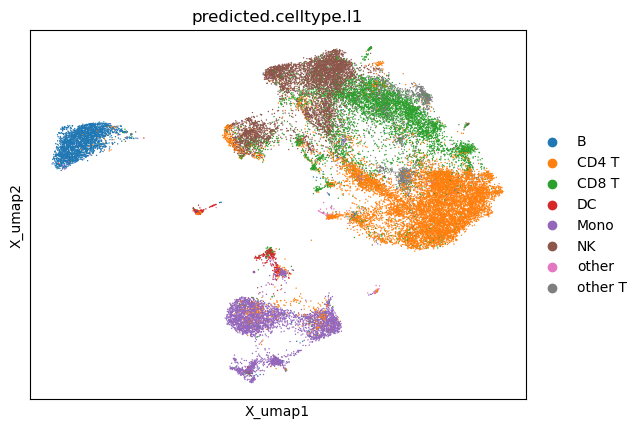

In [27]:
sc.pl.embedding(adata, basis="X_umap", color="predicted.celltype.l1")

In [43]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.layers["soupX_counts"]  # set adata.X to raw counts
sc.pp.normalize_total(
    adata_celltypist, target_sum=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [47]:
import celltypist
from celltypist import models

In [48]:
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 58
📂 Storing models in /home/ozkan.aydemir-umw/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [49]:
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

In [50]:
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)

🔬 Input data has 29930 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6146 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


In [51]:
predictions_high_adata = predictions_high.to_adata()

In [52]:
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]

In [55]:
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)
predictions_low_adata = predictions_low.to_adata()
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]

🔬 Input data has 29930 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6146 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


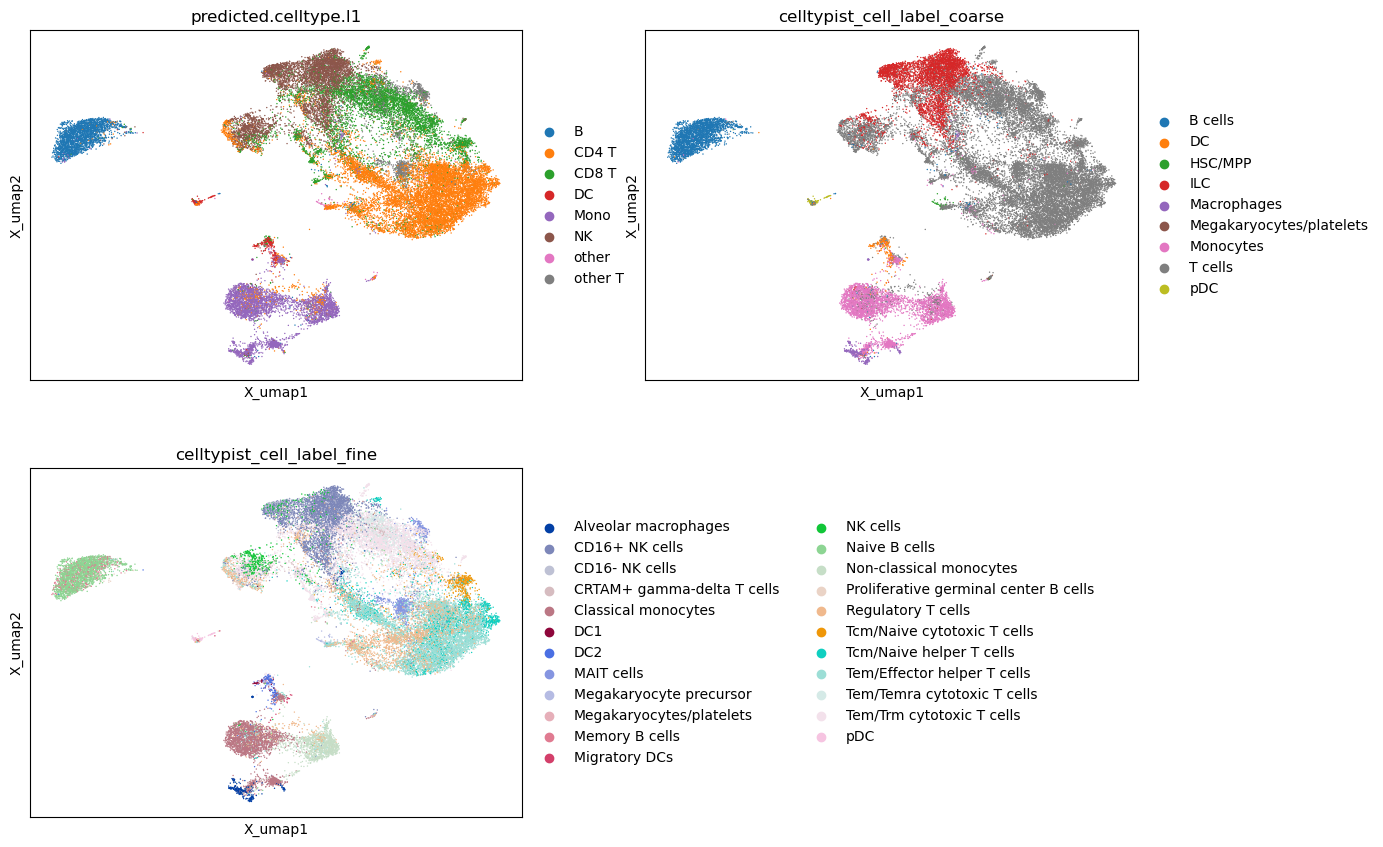

In [58]:
sc.pl.embedding(adata, basis="X_umap", color=["predicted.celltype.l1",
                                              "celltypist_cell_label_coarse",
                                             "celltypist_cell_label_fine"],
               ncols=2)

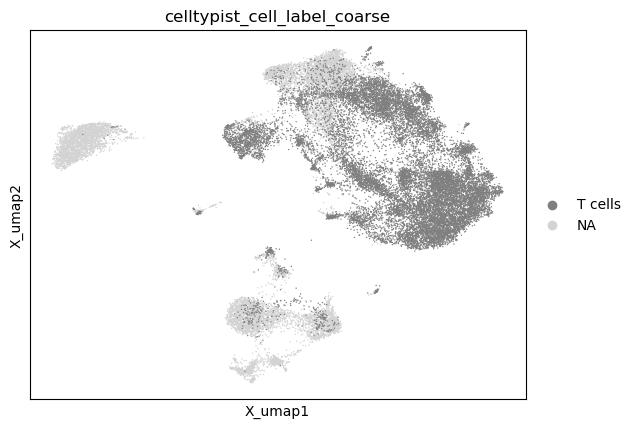

In [59]:
sc.pl.embedding(adata, basis="X_umap", color=["celltypist_cell_label_coarse"],
               groups="T cells")

In [28]:
trgv = ["TRGV2", "TRGV3", "TRGV4", "TRGV5", "TRGV8", "TRGV9"]
MAIT = ["TRAV1-2"]
          
iNKT = ["TRAV24", "TRBV11-1", "TRBV11-2", "TRBV11-3"]
oth = ["TRAV21", "TRAV38-2DV8", "TRAV22", "TRAV12-2",
       "TRAV19", "TRBV7-2", "TRBV12-3"]
tgenes = trgv + MAIT + iNKT + oth

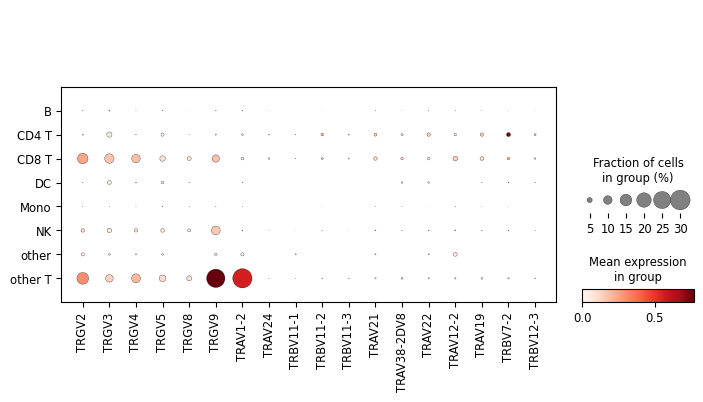

In [29]:
sc.pl.dotplot(adata, layer="soupX_counts", groupby="predicted.celltype.l1", var_names=tgenes, use_raw=False)

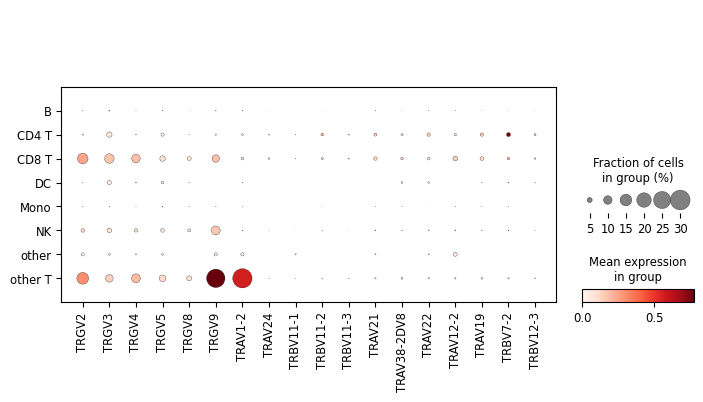

In [30]:
sc.pl.dotplot(adata, layer="counts", groupby="predicted.celltype.l1", var_names=tgenes)

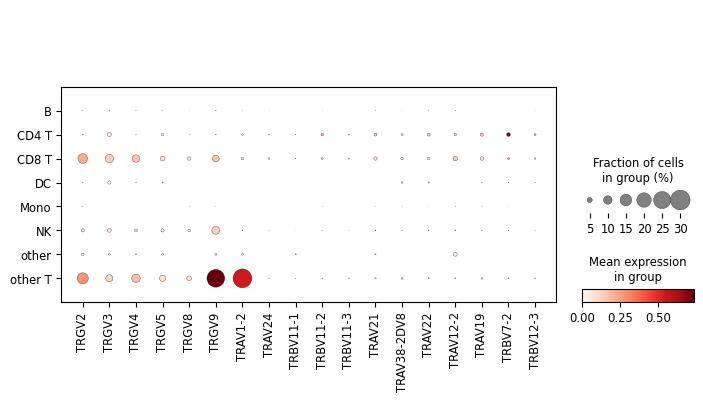

In [31]:
sc.pl.dotplot(adata, layer="soupX_counts_02", groupby="predicted.celltype.l1", var_names=tgenes)

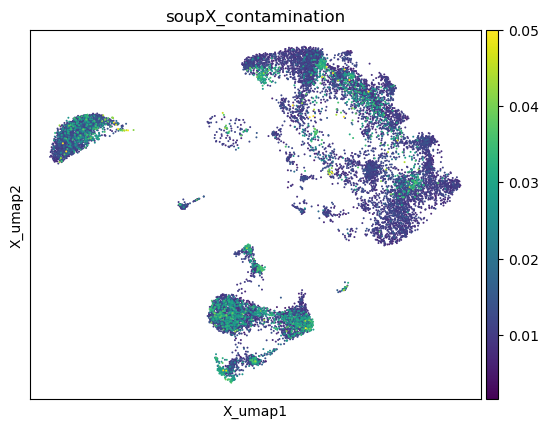

In [41]:
sc.pl.embedding(adata[adata.obs.condition=="PBMC"], layer="soupX_counts", basis="X_umap",
                color="soupX_contamination", vmax=0.05, groups="ASTRL")

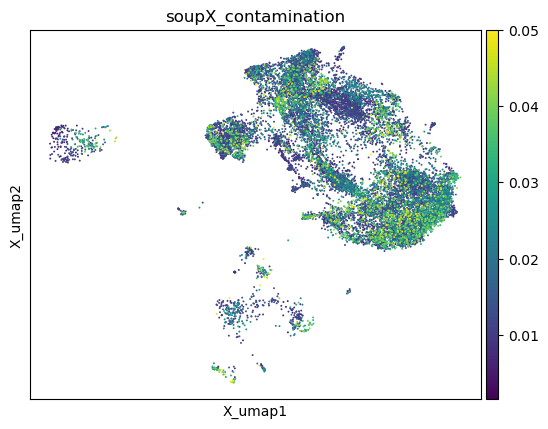

In [40]:
sc.pl.embedding(adata[adata.obs.condition=="ASTRL"], layer="soupX_counts", basis="X_umap",
                color="soupX_contamination", vmax=0.05)

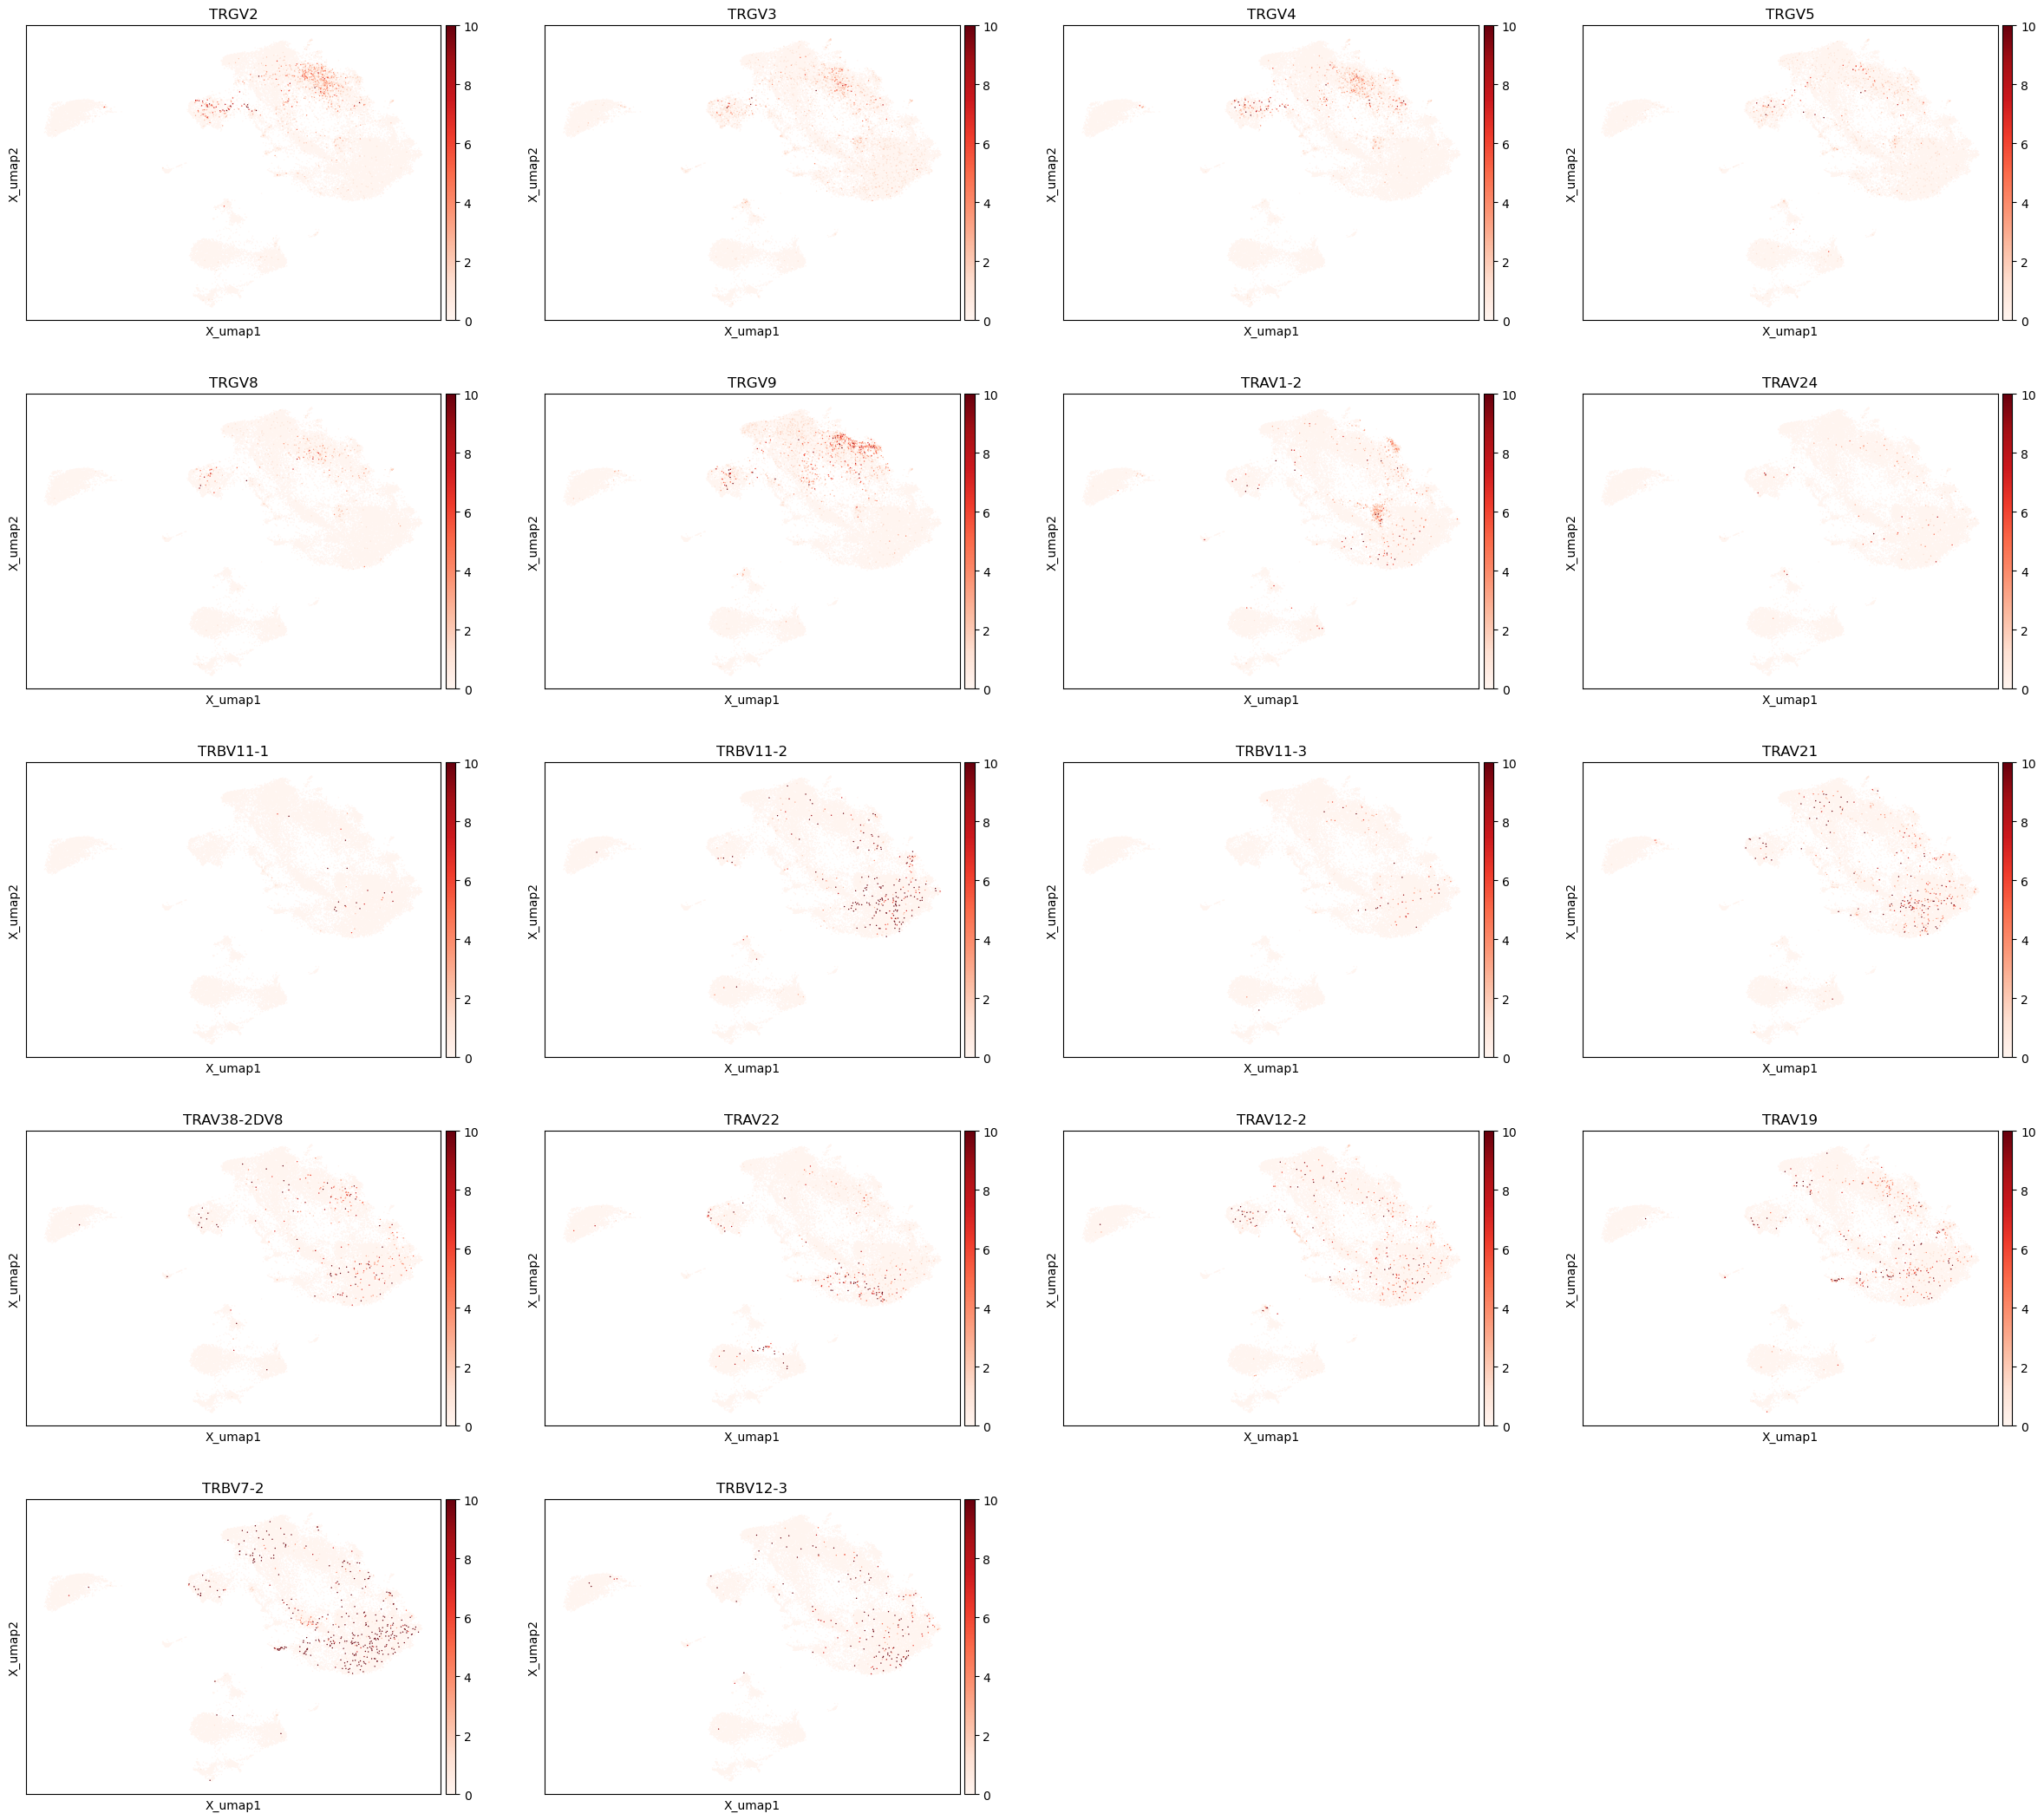

In [42]:
sc.pl.embedding(adata, layer="counts", basis="X_umap", color=tgenes, vmax=10, color_map="Reds")

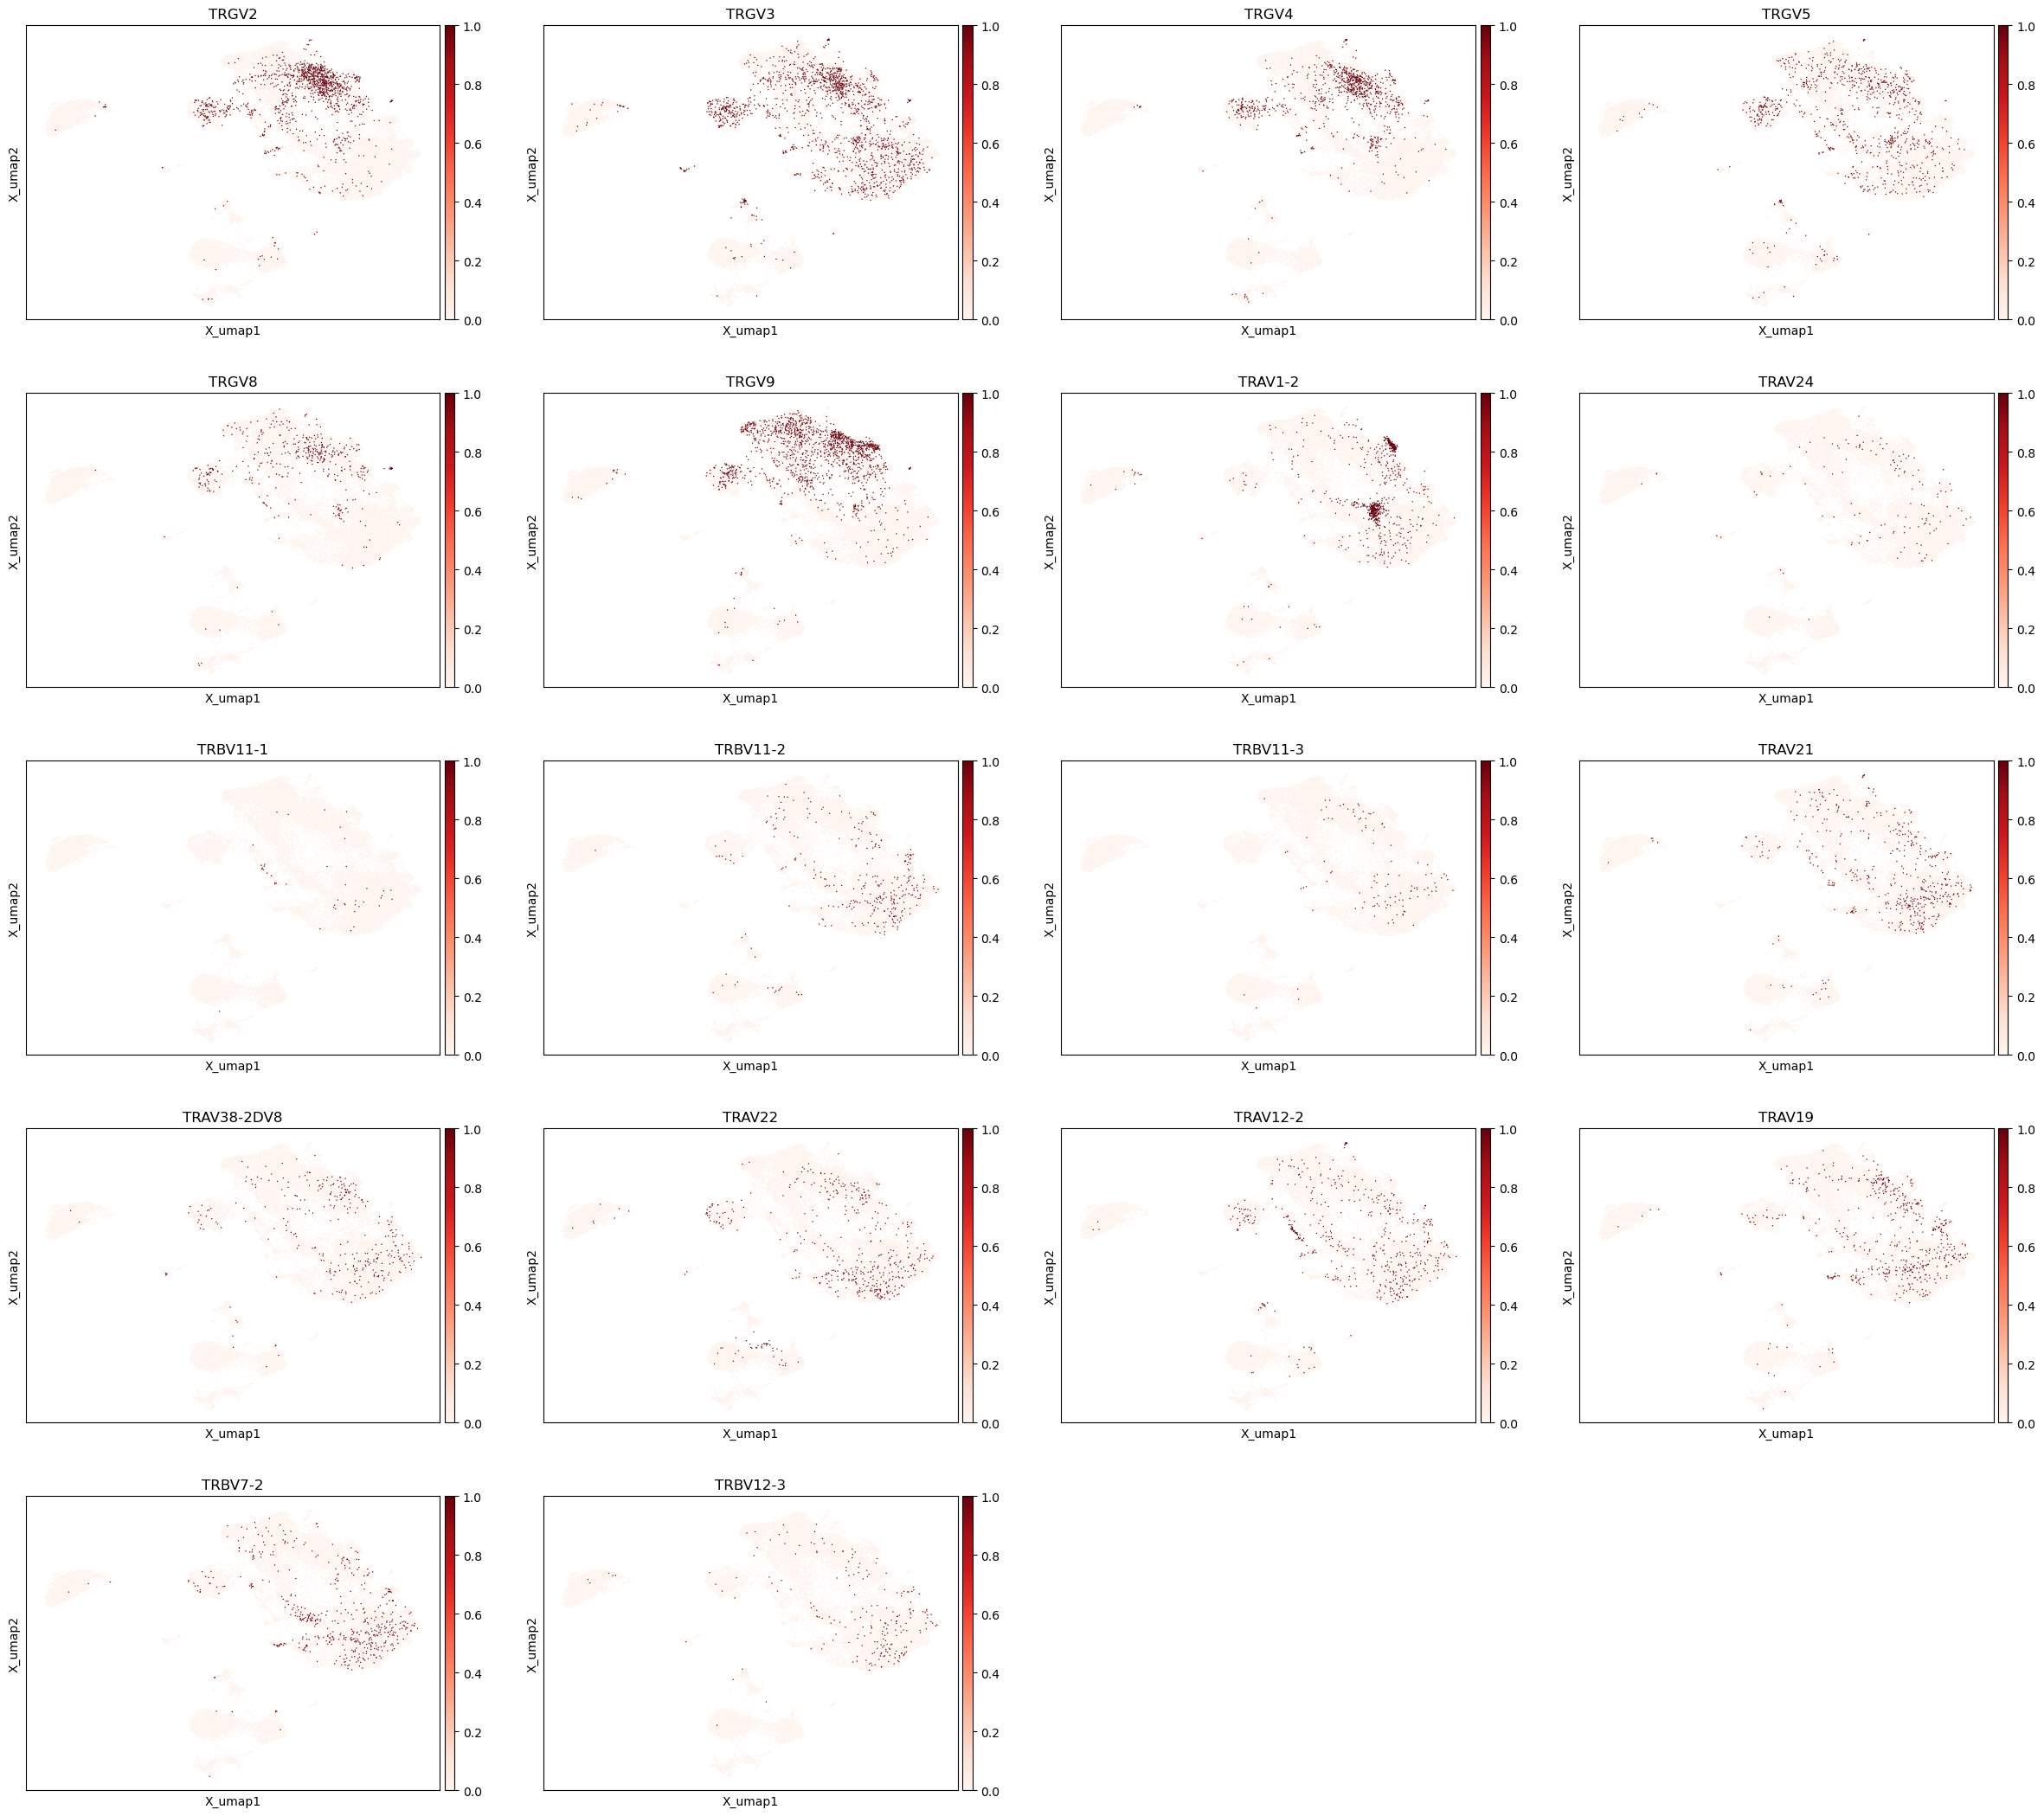

In [59]:
sc.pl.embedding(adata, layer="soupX_counts", basis="X_umap", color=tgenes, vmax=1, color_map="Reds")

In [176]:
diff_df = pd.DataFrame.sparse.from_spmatrix(adata.layers["soupX_counts"] - adata.layers["counts"])

In [197]:
diff_df

0      1      2      3      4      5      6      7      8      9      \
0          0      0      0      0      0      0      0      0      0      0   
1          0      0      0      0      0      0      0      0      0      0   
2          0      0      0      0      0      0      0      0      0      0   
3          0      0      0      0      0      0      0      0      0      0   
4          0      0      0      0      0      0      0      0      0      0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
29925      0      0      0      0      0      0      0      0      0      0   
29926      0      0      0      0      0      0      0      0      0      0   
29927      0      0      0      0      0      0      0      0      0      0   
29928      0      0      0      0      0      0      0      0      0      0   
29929      0      0      0      0      0      0      0      0      0      0   

       ...  36591  36592  36593  36594  36595  36596  36597  36598  36599  \
0      ...      0      0      0      0      0      0      0      0      0   
1      ...      0      0      0      0      0      0      0      0      0   
2      ...      0      0      0      0      0      0      0      0      0   
3      ...      0      0      0      0      0      0      0      0      0   
4      ...      0      0      0      0      0      0      0      0      0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
29925  ...      0      0      0      0      0      0      0      0      0   
29926  ...      0      0      0      0      0      0      0      0      0   
29927  ...      0      0      0      0      0      0      0      0      0   
29928  ...      0      0      0      0      0      0      0      0      0   
29929  ...      0      0      0      0      0      0      0      0      0   

       36600  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
29925      0  
29926      0  
29927      0  
29928      0  
29929      0  

[29930 rows x 36601 columns]

In [190]:
ind = diff_df.sum().sort_values().index

In [111]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts,

RInterpreterError: Failed to parse and evaluate line 'library(Seurat)\nlibrary(scater)\nlibrary(scDblFinder)\nlibrary(BiocParallel)\n'.
R error message: 'Error in library(scDblFinder) : there is no package called ‘scDblFinder’'
R stdout:
Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeightedVars

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:SeuratObject’:

    intersect

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors

Attaching package: ‘S4Vectors’

The following objects are masked from ‘package:Matrix’:

    expand, unname

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges

Attaching package: ‘IRanges’

The following object is masked from ‘package:sp’:

    %over%

Loading required package: GenomeInfoDb
Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Attaching package: ‘Biobase’

The following object is masked from ‘package:MatrixGenerics’:

    rowMedians

The following objects are masked from ‘package:matrixStats’:

    anyMissing, rowMedians


Attaching package: ‘SummarizedExperiment’

The following object is masked from ‘package:Seurat’:

    Assays

The following object is masked from ‘package:SeuratObject’:

    Assays

Loading required package: scuttle
Loading required package: ggplot2
Error in library(scDblFinder) : there is no package called ‘scDblFinder’

In [ ]:
data_mat = adata.X.T